In [10]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [11]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

## Reading Dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : ZkSVP6b3 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : REqQjJkQ
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

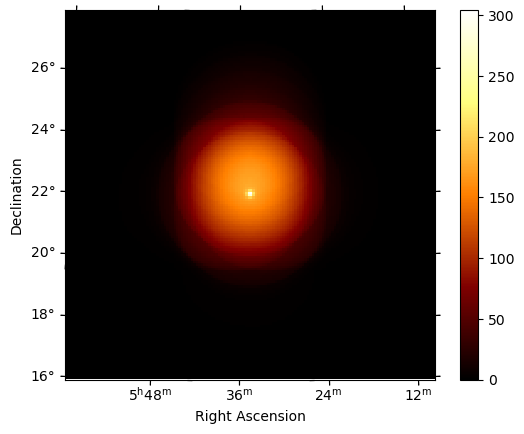

In [12]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'

dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

asimov = True
if asimov:
    dataset_standard.counts = dataset_standard.npred()
    
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
fit = Fit()
result = fit.run(dataset_standard)

## Shifting the Counts

In [13]:
ebin_edges = dataset_standard.geoms['geom'].axes[0].edges.value
ebin_center = dataset_standard.geoms['geom'].axes[0].center.value

counts_ebin = dataset_standard.counts.data.sum(axis = 2).sum(axis = 1)
counts_ebin_err = np.sqrt(dataset_standard.counts.data.sum(axis = 2).sum(axis = 1))



/tmp/ipykernel_1003465/1496321120.py:18: RuntimeWarning: invalid value encountered in log
  return     fac*  (E/E0) ** (index1 - index2* np.log(E/E0))


Text(0.5, 1.0, 'Fitting the Counts')

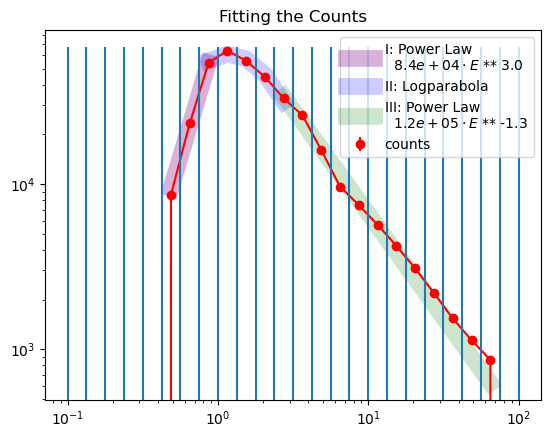

In [14]:
## Case 1
def case1(E, norm, power):
    return norm * E ** power

norm1 = 5e4
power1 = 2.4
id1 = 5,8
e1 = ebin_center[id1[0]: id1[1]]
popt1, pcov = curve_fit(case1, e1, counts_ebin[id1[0]: id1[1]])
plt.plot( e1, 
         case1( ebin_center[id1[0]: id1[1]], popt1[0], popt1[1]),
         label =  f"I: Power Law \n  ${popt1[0]:.2}\cdot E $ ** {popt1[1]:.2} "
         , color = 'purple', linewidth = 12, alpha = 0.3)


# Case 2
def logparabola(E,fac, E0, index1, index2):
    return     fac*  (E/E0) ** (index1 - index2* np.log(E/E0))

E02 = 0.9
fac2 = 4e4
index1 = 2.1
index2 = 2.1
id2_fit= 7,12
e2_fit = ebin_center[id2_fit[0]: id2_fit[1]]
id2= 8,11
e2 = ebin_center[id2[0]: id2[1]]
popt2, pcov = curve_fit(logparabola,  e2_fit, counts_ebin[id2_fit[0]: id2_fit[1]])
plt.plot( e2_fit, 
         logparabola(e2_fit , *popt2),
         label = "II: Logparabola" , color = 'blue', linewidth = 12,
        alpha = 0.2)

norm3 = 8e4
power3 = 2.4
id3 = 11,23
e3 = ebin_center[id3[0]: id3[1]]

popt3, pcov = curve_fit(case1, ebin_center[id3[0]: id3[1]], counts_ebin[id3[0]: id3[1]])
plt.plot( ebin_center[id3[0]: id3[1]], 
         case1( ebin_center[id3[0]: id3[1]], *popt3),
         label = f"III: Power Law \n  ${popt3[0]:.2}\cdot E $ ** {popt3[1]:.2} "
         , color = 'green', linewidth = 12, alpha = 0.2)

plt.plot(ebin_center, counts_ebin, color = 'red')
plt.errorbar(ebin_center, counts_ebin, yerr = counts_ebin_err,fmt= 'o', color = 'red',
            label='counts')


ylim = plt.ylim()
for e in ebin_edges:
    plt.vlines(e, ylim[0], ylim[1])

plt.loglog()
plt.legend()
plt.title("Fitting the Counts")

/tmp/ipykernel_1003465/3474051367.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e1,c1 , 'x', color = 'red', marker = 'x',
/tmp/ipykernel_1003465/3474051367.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e1s, c1s, 'x', marker ='o', color = 'lawngreen',
/tmp/ipykernel_1003465/3474051367.py:37: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e2,c2 , 'x' , color = 'red', marker = 'x')
/tmp/ipykernel_1003465/3474051367.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e2s, c2s, 'x' ,marker 

Text(0.5, 1.0, 'Counts: Shift of 0.8')

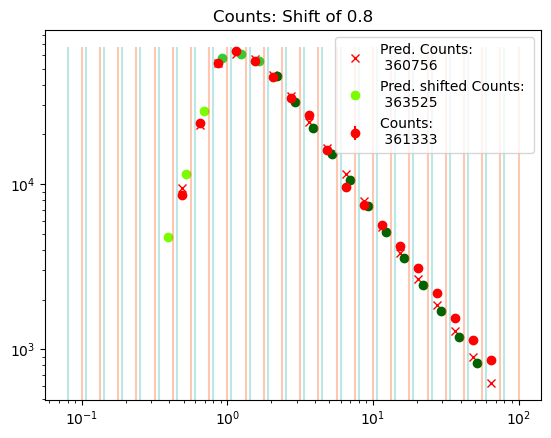

In [15]:
shift = 0.8

ed1 = ebin_edges[id1[0]: id1[1]+1] 
ed2 = ebin_edges[id2[0]: id2[1]+1] 
ed3 = ebin_edges[id3[0]: id3[1]+1] 

c1 = case1(e1, * popt1)
c2 = logparabola(e2, * popt2)
c3 = case1(e3, * popt3)
c = int(np.sum(c1) + sum(c2) + sum(c3))

e1s = e1 * shift
e2s = e2 * shift
e3s = e3 * shift

c1s = case1(e1s, * popt1)
c2s = logparabola(e2s, * popt2)
c3s = case1(e3s, * popt3)
cse = np.append(np.append(c1s, c2s), c3s) 
cs = int(np.sum(c1s) + sum(c2s) + sum(c3s))

data1 = counts_ebin[id1[0]:id1[1]]
data2 = counts_ebin[id2[0]:id2[1]]
data3 = counts_ebin[id3[0]:id3[1]]
datae = np.append(np.append(data1, data2), data3) 
data = int(np.sum(data1) + sum(data2) + sum(data3))

plt.errorbar(ebin_center[id1[0]:id1[1]],data1 ,    yerr = np.sqrt(data1), 
             fmt= 'o', color = 'red', 
             label = f'Counts: \n {data}')
plt.plot(e1,c1 , 'x', color = 'red', marker = 'x',
        label = f"Pred. Counts: \n {c}")
plt.plot(e1s, c1s, 'x', marker ='o', color = 'lawngreen',
         label = f"Pred. shifted Counts: \n {cs}")


plt.plot(e2,c2 , 'x' , color = 'red', marker = 'x')
plt.plot(e2s, c2s, 'x' ,marker ='o', color = 'limegreen')
plt.errorbar(ebin_center[id2[0]:id2[1]],data2 ,
             yerr = np.sqrt(data2), fmt= 'o', color = 'red')
    
plt.plot(e3,c3 , 'x', color = 'red', marker = 'x')
plt.plot(e3s, c3s, 'x', marker ='o', color = 'darkgreen')
plt.errorbar(ebin_center[id3[0]:id3[1]],data3 ,
             yerr = np.sqrt(data3), fmt= 'o', color = 'red')

for e in ebin_edges:
    plt.vlines(e, ylim[0], ylim[1], alpha = 0.3, color = 'orangered')
    plt.vlines(e * shift, ylim[0], ylim[1], color = 'lightseagreen', alpha = 0.3)
    

plt.loglog()
plt.legend()
plt.title(f"Counts: Shift of {shift}")



### Shifting the BkG

In [16]:
bkg_ebin = dataset_standard.background.data.sum(axis = 2).sum(axis = 1)
bkg_ebin_err = np.sqrt(dataset_standard.background.data.sum(axis = 2).sum(axis = 1))



/tmp/ipykernel_1003465/3639495952.py:17: RuntimeWarning: invalid value encountered in log
  return     fac*  (E/E0) ** (index1 - index2* np.log(E/E0))


Text(0.5, 1.0, 'Fitting the bkg')

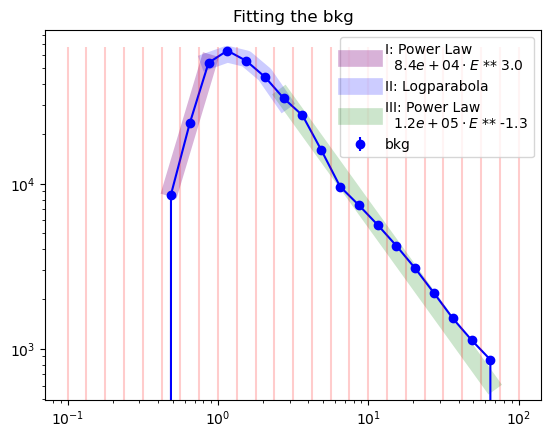

In [17]:
## Case 1
def case1(E, norm, power):
    return norm * E ** power

norm1 = 5e4
power1 = 2.4
id1 = 5,8
e1 = ebin_center[id1[0]: id1[1]]
poptbkg1, pcov = curve_fit(case1, e1, bkg_ebin[id1[0]: id1[1]])
plt.plot( e1, 
         case1( ebin_center[id1[0]: id1[1]], poptbkg1[0], poptbkg1[1]),
         label = f"I: Power Law \n  ${poptbkg1[0]:.2}\cdot E $ ** {poptbkg1[1]:.2} " , color = 'purple', linewidth = 12, alpha = 0.3)


# Case 2
def logparabola(E,fac, E0, index1, index2):
    return     fac*  (E/E0) ** (index1 - index2* np.log(E/E0))

E02 = 0.9
fac2 = 4e4
index1 = 2.1
index2 = 2.1
id2_fit= 7,12
e2_fit = ebin_center[id2_fit[0]: id2_fit[1]]
id2= 8,11
e2 = ebin_center[id2[0]: id2[1]]
poptbkg2, pcov = curve_fit(logparabola,  e2_fit, bkg_ebin[id2_fit[0]: id2_fit[1]])
plt.plot( e2_fit, 
         logparabola(e2_fit , *poptbkg2),
         label = f"II: Logparabola" 
         , color = 'blue', linewidth = 12,
        alpha = 0.2)

norm3 = 8e4
power3 = 2.4
id3 = 11,23
e3 = ebin_center[id3[0]: id3[1]]

poptbkg3, pcov = curve_fit(case1, ebin_center[id3[0]: id3[1]], bkg_ebin[id3[0]: id3[1]])
plt.plot( ebin_center[id3[0]: id3[1]], 
         case1( ebin_center[id3[0]: id3[1]], *poptbkg3),
         label = f"III: Power Law \n  ${poptbkg3[0]:.2}\cdot E $ ** {poptbkg3[1]:.2} " ,
         color = 'green', linewidth = 12, alpha = 0.2)

plt.plot(ebin_center, bkg_ebin, color = 'blue')
plt.errorbar(ebin_center, bkg_ebin, yerr = bkg_ebin_err,fmt= 'o', color = 'blue',
            label='bkg')


ylim = plt.ylim()
for e in ebin_edges:
    plt.vlines(e, ylim[0], ylim[1], color = 'red', alpha = 0.2)

plt.loglog()
plt.legend()
plt.title("Fitting the bkg")

/tmp/ipykernel_1003465/1457476963.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e1,c1 , 'x', color = 'blue', marker = 'x',
/tmp/ipykernel_1003465/1457476963.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e1s, c1s, 'x', marker ='o', color = 'violet',
/tmp/ipykernel_1003465/1457476963.py:35: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e2,c2 , 'x' , color = 'blue', marker = 'x')
/tmp/ipykernel_1003465/1457476963.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(e2s, c2s, 'x' ,marker =

Text(0.5, 1.0, 'bkg: Shift of 0.8')

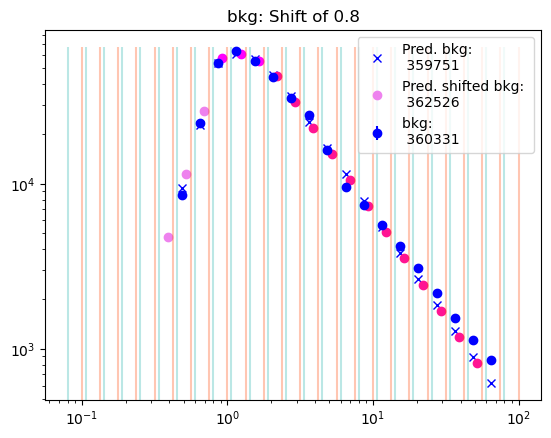

In [18]:
ed1 = ebin_edges[id1[0]: id1[1]+1] 
ed2 = ebin_edges[id2[0]: id2[1]+1] 
ed3 = ebin_edges[id3[0]: id3[1]+1] 

c1 = case1(e1, * poptbkg1)
c2 = logparabola(e2, * poptbkg2)
c3 = case1(e3, * poptbkg3)
c = int(np.sum(c1) + sum(c2) + sum(c3))

e1s = e1 * shift
e2s = e2 * shift
e3s = e3 * shift

c1s = case1(e1s, * poptbkg1)
c2s = logparabola(e2s, * poptbkg2)
c3s = case1(e3s, * poptbkg3)
cse_bkg = np.append(np.append(c1s, c2s), c3s) 
cs = int(np.sum(c1s) + sum(c2s) + sum(c3s))

data1 = bkg_ebin[id1[0]:id1[1]]
data2 = bkg_ebin[id2[0]:id2[1]]
data3 = bkg_ebin[id3[0]:id3[1]]
datae_bkg = np.append(np.append(data1, data2), data3) 
data = int(np.sum(data1) + sum(data2) + sum(data3))

plt.errorbar(ebin_center[id1[0]:id1[1]],data1 ,    yerr = np.sqrt(data1), 
             fmt= 'o', color = 'blue', 
             label = f'bkg: \n {data}')
plt.plot(e1,c1 , 'x', color = 'blue', marker = 'x',
        label = f"Pred. bkg: \n {c}")
plt.plot(e1s, c1s, 'x', marker ='o', color = 'violet',
         label = f"Pred. shifted bkg: \n {cs}")


plt.plot(e2,c2 , 'x' , color = 'blue', marker = 'x')
plt.plot(e2s, c2s, 'x' ,marker ='o', color = 'magenta')
plt.errorbar(ebin_center[id2[0]:id2[1]],data2 ,
             yerr = np.sqrt(data2), fmt= 'o', color = 'blue')
    
plt.plot(e3,c3 , 'x', color = 'blue', marker = 'x')
plt.plot(e3s, c3s, 'x', marker ='o', color = 'deeppink')
plt.errorbar(ebin_center[id3[0]:id3[1]],data3 ,
             yerr = np.sqrt(data3), fmt= 'o', color = 'blue')

for e in ebin_edges:
    plt.vlines(e, ylim[0], ylim[1], alpha = 0.3, color = 'orangered')
    plt.vlines(e * shift, ylim[0], ylim[1], color = 'lightseagreen', alpha = 0.3)
    

plt.loglog()
plt.legend()
plt.title(f"bkg: Shift of {shift}")



### making it 3D again

#### New geometry

In [19]:
geom = dataset_standard.geoms['geom']
shifted_eaxis = MapAxis(nodes = geom.axes[0].edges * shift, interp='log', name='energy', node_type='edges')
geom_shifted = geom.copy().to_image()
geom_shifted = geom_shifted.to_cube([shifted_eaxis])
ebin_center_shifted = geom_shifted.axes[0].center.value
print(geom_shifted)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (150, 150, 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 12.0 deg x 12.0 deg
	wcs ref    : 83.6 deg, 22.0 deg



In [20]:
counts_shifted = Map.from_geom(geom_shifted)
bkg_shifted = Map.from_geom(geom_shifted)

for i, e in enumerate(shifted_eaxis.center.value):
    if i >= id1[0] and i < id3[1]:
        factor = cse[i-id1[0]] / datae[i-id1[0]] 
        counts_shifted.data[i,:,:] = factor * dataset_standard.counts.data[i,:,:]
        
        factor_bkg = cse_bkg[i-id1[0]] / datae_bkg[i-id1[0]] 
        bkg_shifted.data[i,:,:] = factor_bkg * dataset_standard.background.data[i,:,:]
        


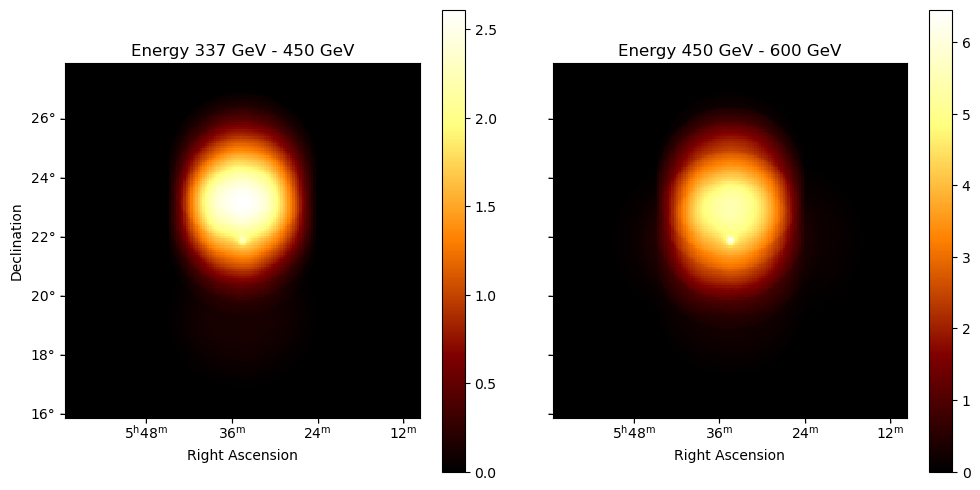

In [21]:
slices = {"energy": slice(5,7)} 
counts_shifted.slice_by_idx(slices).plot_grid(add_cbar =1);

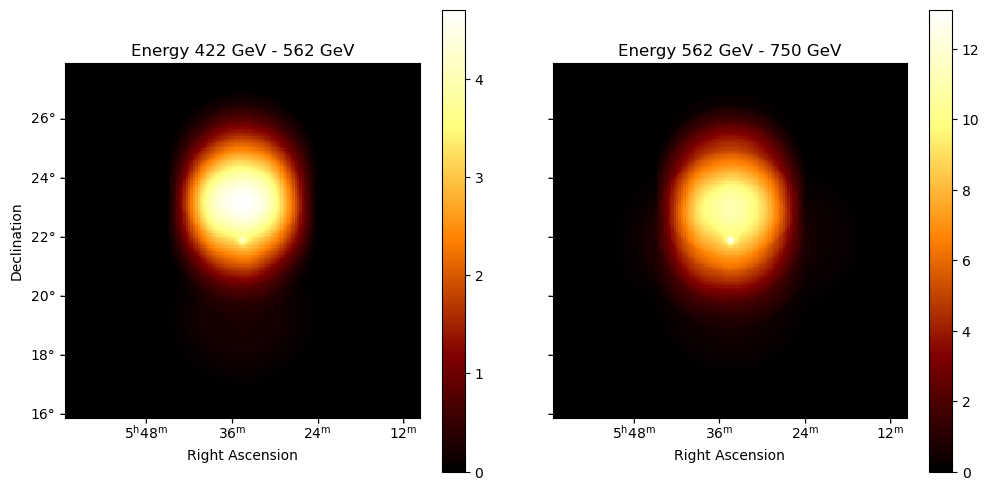

In [22]:
dataset_standard.counts.slice_by_idx(slices).plot_grid(add_cbar = 1);

Text(0.5, 1.0, 'BKG')

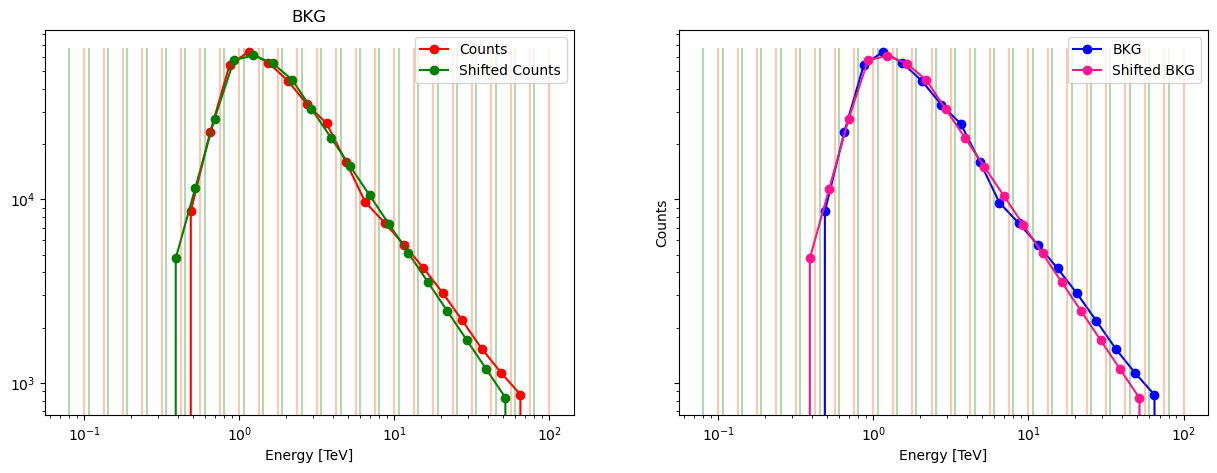

In [23]:
fig, axs = plt.subplots(1,2, sharey=True, figsize = (15,5))
axs[0].plot(ebin_center, counts_ebin, label = "Counts", color = 'red', marker ='o')
axs[0].plot(ebin_center_shifted, counts_shifted.data.sum(axis=2).sum(axis=1), label = "Shifted Counts", color = "green",
        marker = 'o')

plt.plot(ebin_center, bkg_ebin, label = "BKG", color = 'blue', marker ='o')
plt.plot(ebin_center_shifted, bkg_shifted.data.sum(axis=2).sum(axis=1), label = "Shifted BKG", color = "deeppink",
        marker = 'o')

ylim = axs[0].get_ylim()
for e in ebin_edges:
    for a in axs:
        a.vlines(e, ylim[0], ylim[1], alpha = 0.3, color = 'orangered')
        a.vlines(e * shift, ylim[0], ylim[1], color = 'green', alpha = 0.3)
    
for a in axs:
    a.loglog()
    a.legend()
    a.set_xlabel("Energy [TeV]") ;
    #a.set_xlim(2, 60)
plt.ylabel("Counts")
axs[0].set_title("Counts")
axs[0].set_title("BKG")

In [24]:
geom_edisp_shifted = dataset_standard.edisp.edisp_map.geom.to_image()
geom_edisp_shifted = geom_edisp_shifted.to_cube([shifted_eaxis,
                                                 dataset_standard.edisp.edisp_map.geom.axes['energy_true'],
                           ])
edisp_shifted = Map.from_geom(geom_edisp_shifted,
                             data = dataset_standard.edisp.edisp_map.data)
edisp_shifted

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy', 'energy_true']
	shape : (60, 60, 24, 24)
	ndim  : 4
	unit  : 
	dtype : >f4

## Creating the shifted Dataset

In [25]:
dataset_shifted = dataset_standard.copy()
dataset_shifted.counts = counts_shifted
dataset_shifted.background = bkg_shifted
dataset_shifted.edisp.edisp_map = edisp_shifted
dataset_shifted._background_cached = None
#dataset_shifted.mask_fit = dataset_shifted.mask_fit.resample_axis(shifted_eaxis)
dataset_shifted.mask_safe = Map.from_geom(geom_shifted,
                                         data = dataset_standard.mask.data)

dataset_shifted.mask_safe.resample_axis(shifted_eaxis)
dataset_shifted.write(f"stacked_shifted{shift}.fits",
                     overwrite = True)


